# Homework 1

## FINM 36700 - 2024

### UChicago Financial Mathematics

* Matheus Raka Pradnyatama
* matheusraka@uchicago.edu

## HBS Case

### *The Harvard Management Company and Inflation-Indexed Bonds*

### Notation
(Hidden LaTeX commands)

$$\newcommand{\mux}{\tilde{\boldsymbol{\mu}}}$$
$$\newcommand{\wtan}{\boldsymbol{\text{w}}^{\text{tan}}}$$
$$\newcommand{\wtarg}{\boldsymbol{\text{w}}^{\text{port}}}$$
$$\newcommand{\mutarg}{\tilde{\boldsymbol{\mu}}^{\text{port}}}$$
$$\newcommand{\wEW}{\boldsymbol{\text{w}}^{\text{EW}}}$$
$$\newcommand{\wRP}{\boldsymbol{\text{w}}^{\text{RP}}}$$
$$\newcommand{\wREG}{\boldsymbol{\text{w}}^{\text{REG}}}$$

***

# 1. HMC's Approach

**Section 1 is not graded**, and you do not need to submit your answers. But you are encouraged to think about them, and we will discuss them.

### 1. 
There are thousands of individual risky assets in which HMC can invest.  Explain why MV optimization across 1,000 securities is infeasible.

### 2.
Rather than optimize across all securities directly, HMC runs a two-stage optimization.
1. They build asset class portfolios with each one optimized over the securities of the specific asset class.  
2. HMC combines the asset-class portfolios into one total optimized portfolio.

In order for the two-stage optimization to be a good approximation of the full MV-optimization on all assets, what must be true of the partition of securities into asset classes?

### 3.
Should TIPS form a new asset class or be grouped into one of the other 11 classes?

### 4. 
Why does HMC focus on real returns when analyzing its portfolio allocation? Is this just a matter of scaling, or does using real returns versus nominal returns potentially change the MV solution?

### 5.
The case discusses the fact that Harvard places bounds on the portfolio allocation rather than implementing whatever numbers come out of the MV optimization problem.

How might we adjust the stated optimization problem in the lecture notes to reflect the extra constraints Harvard is using in their bounded solutions given in Exhibits 5 and 6?

### 6. 
Exhibits 5 shows zero allocation to domestic equities and domestic bonds across the entire computed range of targeted returns, (5.75% to 7.25%). Conceptually, why is the constraint binding in all these cases? What would the unconstrained portfolio want to do with those allocations and why?

### 7.
Exhibit 6 changes the constraints, (tightening them in most cases.) How much deterioration do we see in the mean-variance tradeoff that Harvard achieved?

***

# 2 Mean-Variance Optimization

<i>This section is graded for a good-faith effort by your group. Submit your write-up- along with your supporting code. </i>

### Data
You will need the file in the github repo, `data/multi_asset_etf_data.xlsx`.
- The time-series data gives monthly returns for the 11 asset classes and a short-term Treasury-bill fund return, ("SHV",) which we consider as the risk-free rate.
- The data is provided in total returns, (in which case you should ignore the SHV column,) as well as excess returns, (where SHV has been subtracted from the other columns.)
- These are nominal returns-they are not adjusted for inflation, and in our calculations we are not making any adjustment for inflation.
- The exhibit data that comes via Harvard with the case is unnecessary for our analysis.

### Model
We are going to analyze the problem in terms of **excess** returns.
- Thus, you will focus on the `Excess Returns` section of the lecture notes, especially the formulas on slide 50.
- Be sure to use the`excess returns` tab of the data.

### Format
In the questions below, **annualize the statistics** you report.
- Annualize the mean of monthly returns with a scaling of 12.
- Annualize the volatility of monthly returns with a scaling of $\sqrt{12}$
- The Sharpe Ratio is the mean return divided by the volatility of returns. Accordingly, we can annualize the Sharpe Ratio with a scaling of $\sqrt{12}$
- Note that we are not scaling the raw timeseries data, just the statistics computed from it (mean, vol, Sharpe). 

### Footnotes

#### Data File
* The case does not give time-series data, so this data has been compiled outside of the case, and it intends to represent the main asset classes under consideration via various ETFs. For details on the specific securities/indexes, check the “Info” tab of the data.

#### Risk-free rate
* In the lecture-note we considered a constant risk-free rate. It is okay that our risk-free rate changes over time, but the assumption is that investors know it’s value one-period ahead of time. Thus, at any given point in time, it is a risk-free rate for the next period. (This is often discussed as the "bank account" or "money market account" in other settings.

In [2]:
import pandas as pd
import numpy as np
pd.options.display.float_format = "{:,.4f}".format

import matplotlib.pyplot as plt
import seaborn as sns

import statsmodels.api as sm
from sklearn.linear_model import LinearRegression
from typing import Union, List

import warnings
warnings.filterwarnings("ignore")

In [3]:
def summary_statistics_annualized(returns, annual_factor = 12):
    """This functions returns the summary statistics for the input total/excess returns passed
    into the function"""
    
    summary_statistics = pd.DataFrame(index=returns.columns)
    summary_statistics['Mean'] = returns.mean() * annual_factor
    summary_statistics['Vol'] = returns.std() * np.sqrt(annual_factor)
    summary_statistics['Sharpe'] = (returns.mean() / returns.std()) * np.sqrt(annual_factor)
    #summary_statistics['Min'] = returns.min()
    #summary_statistics['Max'] = returns.max()
    #summary_statistics['Skewness'] = returns.skew()
    #summary_statistics['Excess Kurtosis'] = returns.kurtosis()
    #summary_statistics['VaR (0.05)'] = returns.quantile(.05, axis = 0)
    #summary_statistics['CVaR (0.05)'] = returns[returns <= returns.quantile(.05, axis = 0)].mean()
    
    return summary_statistics

In [4]:
def tangency_weights(returns, cov_mat = 1):
    returns = returns.drop(['Date'], axis=1)

    if cov_mat == 1:
        cov_inv = np.linalg.inv((returns.cov()*12))
    else:
        cov = returns.cov()
        covmat_diag = np.diag(np.diag(cov))
        covmat = cov_mat * cov + (1 - cov_mat) * covmat_diag
        cov_inv = np.linalg.inv((covmat * 12))
    
    ones = np.ones(returns.columns.shape)
    mu = returns.mean() * 12
    scaling = 1 / (np.transpose(ones) @ cov_inv @ mu)
    tangent_return = scaling * (cov_inv @ mu)
    tangency_wts = pd.DataFrame(index=returns.columns, data=tangent_return, columns=['Tangent Weights'])

    return tangency_wts

In [50]:
def calc_correlations(
    returns: pd.DataFrame,
    print_highest_lowest: bool = True,
    matrix_size: Union[int, float] = 7,
    return_heatmap: bool = True,
    keep_columns: Union[list, str] = None,
    drop_columns: Union[list, str] = None,
    keep_indexes: Union[list, str] = None,
    drop_indexes: Union[list, str] = None,
    drop_before_keep: bool = False
):
    returns = returns.copy()

    if 'date' in returns.columns.str.lower():
        returns = returns.rename({'Date': 'date'}, axis=1)
        returns = returns.set_index('date')
    returns.index.name = 'date'


    correlation_matrix = returns.corr()
    if return_heatmap:
        fig, ax = plt.subplots(figsize=(matrix_size * 1.5, matrix_size))
        heatmap = sns.heatmap(
            correlation_matrix, 
            xticklabels=correlation_matrix.columns,
            yticklabels=correlation_matrix.columns,
            annot=True,
        )

    if print_highest_lowest:
        highest_lowest_corr = (
            correlation_matrix
            .unstack()
            .sort_values()
            .reset_index()
            .set_axis(['asset_1', 'asset_2', 'corr'], axis=1)
            .loc[lambda df: df.asset_1 != df.asset_2]
        )
        highest_corr = highest_lowest_corr.iloc[lambda df: len(df)-1, :]
        lowest_corr = highest_lowest_corr.iloc[0, :]
        print(f'The highest correlation ({highest_corr["corr"]:.2%}) is between {highest_corr.asset_1} and {highest_corr.asset_2}')
        print(f'The lowest correlation ({lowest_corr["corr"]:.2%}) is between {lowest_corr.asset_1} and {lowest_corr.asset_2}')
    
    if return_heatmap:
        return heatmap
    else:
        return filter_columns_and_indexes(
            correlation_matrix,
            keep_columns=keep_columns,
            drop_columns=drop_columns,
            keep_indexes=keep_indexes,
            drop_indexes=drop_indexes,
            drop_before_keep=drop_before_keep
        )

In [51]:
def calc_cummulative_returns(
    returns: Union[pd.DataFrame, pd.Series],
    return_plot: bool = True,
    fig_size: tuple = (7, 5),
    return_series: bool = False,
    name: str = None,
    timeframes: Union[None, dict] = None,
):
    if timeframes is not None:
        for name, timeframe in timeframes.items():
            if timeframe[0] and timeframe[1]:
                timeframe_returns = returns.loc[timeframe[0]:timeframe[1]]
            elif timeframe[0]:
                timeframe_returns = returns.loc[timeframe[0]:]
            elif timeframe[1]:
                timeframe_returns = returns.loc[:timeframe[1]]
            else:
                timeframe_returns = returns.copy()
            if len(timeframe_returns.index) == 0:
                raise Exception(f'No returns for {name} timeframe')
            calc_cummulative_returns(
                timeframe_returns,
                return_plot=True,
                fig_size=fig_size,
                return_series=False,
                name=name,
                timeframes=None
            )
        return
    returns = returns.copy()
    if isinstance(returns, pd.Series):
        returns = returns.to_frame()
    returns = returns.apply(lambda x: x.astype(float))
    returns = returns.apply(lambda x: x + 1)
    returns = returns.cumprod()
    returns = returns.apply(lambda x: x - 1)
    title = f'Cummulative Returns {name}' if name else 'Cummulative Returns'
    if return_plot:
        returns.plot(
            title=title,
            figsize=fig_size,
            grid=True,
            xlabel='Date',
            ylabel='Cummulative Returns'
        )
    if return_series:
        return returns

In [5]:
multiassetETF_data = '/Users/matheus/Desktop/finm-portfolio-2024/data/multi_asset_etf_data.xlsx'
multi_asset_etf_descriptions = pd.read_excel(multiassetETF_data)
multi_asset_etf_prices = pd.read_excel(multiassetETF_data, sheet_name = 'prices')

multi_asset_etf_tot_ret = pd.read_excel(multiassetETF_data, sheet_name = 'total returns')
risk_free_rate = multi_asset_etf_tot_ret.loc[:,['SHV']]
multi_asset_etf_tot_ret = multi_asset_etf_tot_ret.drop('SHV', axis = 1)

multi_asset_etf_excess_ret = pd.read_excel(multiassetETF_data, sheet_name = 'excess returns')
excess_returns = multi_asset_etf_excess_ret[multi_asset_etf_excess_ret.columns[1:]] 

multi_asset_etf_excess_ret.head(2)

,Date,BWX,DBC,EEM,EFA,HYG,IEF,IYR,PSP,QAI,SPY,TIP
0,2011-02-28,0.0065,0.0416,-0.0005,0.0354,0.0143,-0.0022,0.0451,0.0401,0.0025,0.0346,0.0071
1,2011-03-31,0.0083,0.0264,0.0627,-0.0241,0.0003,-0.0017,-0.0111,0.0165,0.0053,-0.0001,0.0117


## 1. Summary Statistics
* Calculate and display the mean and volatility of each asset’s excess return. (Recall we use volatility to refer to standard deviation.)
* Which assets have the best and worst Sharpe ratios? Recall that the Sharpe Ratio is simply the ratio of the mean-to-volatility of excess returns:
$$\text{sharpe ratio of investment }i = \frac{\mux_i}{\sigma_i}$$

## 2. Descriptive Analysis
* Calculate the correlation matrix of the returns. Which pair has the highest correlation? And the lowest?
* How well have TIPS done in our sample? Have they outperformed domestic bonds? Foreign bonds?

## 3. The MV frontier.
* Compute and display the weights of the tangency portfolios: $\wtan$.
* Does the ranking of weights align with the ranking of Sharpe ratios?
* Compute the mean, volatility, and Sharpe ratio for the tangency portfolio corresponding to
$\wtan$.

## 4. TIPS
Assess how much the tangency portfolio (and performance) change if...
* TIPS are dropped completely from the investment set.
* The expected excess return to TIPS is adjusted to be 0.0012 higher than what the historic sample shows.

Based on the analysis, do TIPS seem to expand the investment opportunity set, implying that Harvard should consider them as a separate asset?

***

## 2.1

In [6]:
summary_stats_excess_returns = summary_statistics_annualized(excess_returns, annual_factor = 12)
summary_stats_excess_returns

,Mean,Vol,Sharpe
BWX,-0.0119,0.0817,-0.1456
DBC,-0.0091,0.1685,-0.0539
EEM,0.0270,0.1799,0.1498
EFA,0.0550,0.1522,0.3616
HYG,0.0374,0.0773,0.4833
IEF,0.0139,0.0632,0.2206
IYR,0.0779,0.1696,0.4594
PSP,0.0929,0.2152,0.4314
QAI,0.0150,0.0490,0.3052
SPY,0.1270,0.1431,0.8876


In [7]:
print("The asset with the best Sharpe ratio is: ")
display(summary_stats_excess_returns[summary_stats_excess_returns['Sharpe'] == summary_stats_excess_returns['Sharpe'].max()][['Sharpe']])
print("The asset with the worst Sharpe ratio is: ")
display(summary_stats_excess_returns[summary_stats_excess_returns['Sharpe'] == summary_stats_excess_returns['Sharpe'].min()][['Sharpe']])

The asset with the best Sharpe ratio is: 


,Sharpe
SPY,0.8876


The asset with the worst Sharpe ratio is: 


,Sharpe
BWX,-0.1456


## 2.2 Descriptive Analysis

<Axes: >

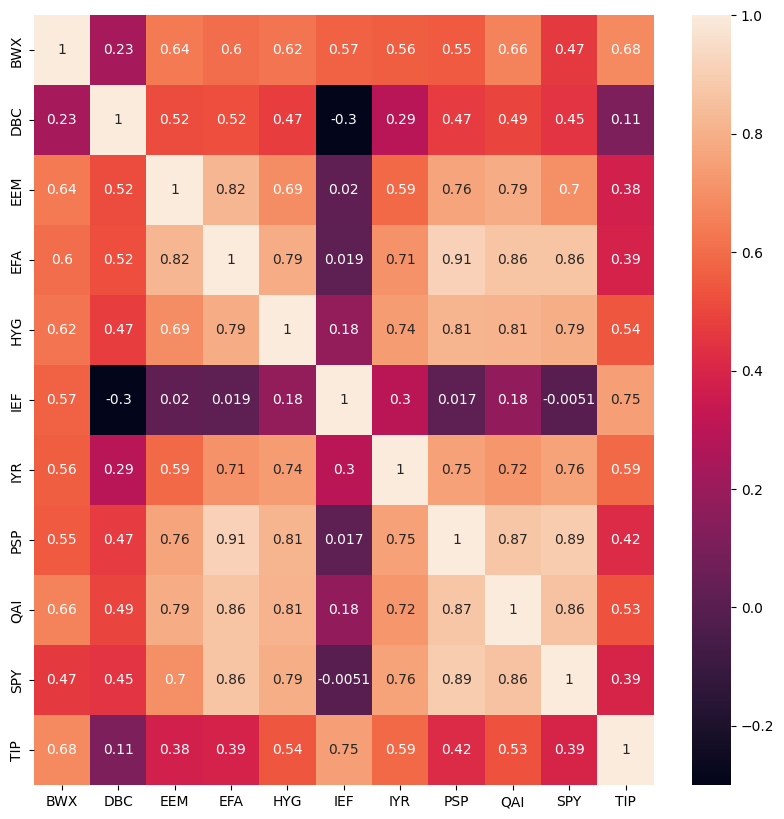

In [8]:
fig, ax = plt.subplots(figsize=(10,10))
correlation_matrix = excess_returns.corr()
sns.heatmap(correlation_matrix, 
        xticklabels=correlation_matrix.columns,
        yticklabels=correlation_matrix.columns, annot=True)

In [9]:
# Ranking the correlation and obtaining the max and min correlation 
corr_rank = correlation_matrix.unstack().sort_values().to_frame('Correlations')
corr_rank = corr_rank[corr_rank['Correlations']!=1]
pair_max = corr_rank.index[-1]
pair_min = corr_rank.index[0]

print(f'Pair with the lowest correlation: {pair_min}')
print(f'Pair with the highest correlation: {pair_max}')

Pair with the lowest correlation: ('IEF', 'DBC')
Pair with the highest correlation: ('EFA', 'PSP')


The highest correlation (91.06%) is between EFA and PSP
The lowest correlation (-30.05%) is between IEF and DBC


<Axes: >

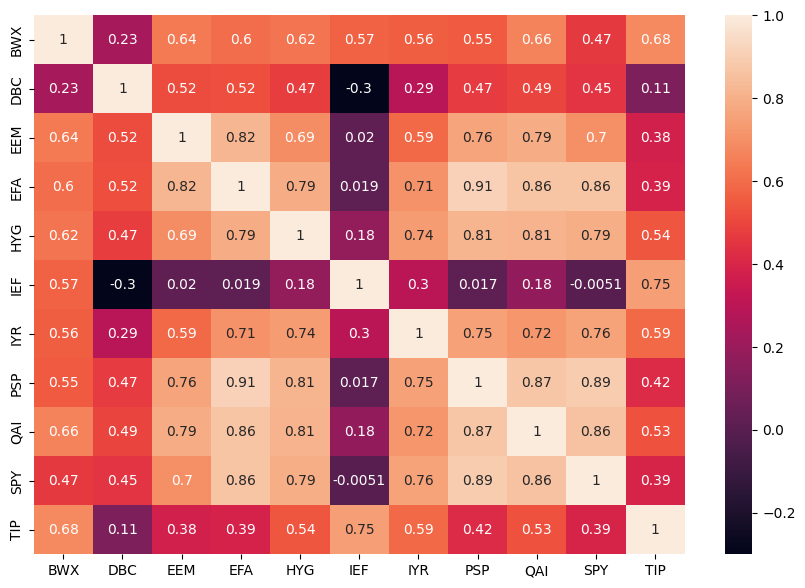

In [11]:
calc_correlations(excess_returns)

In [12]:
# Replace the diagonal values (1s) with NaN to ignore them
correlation_matrix_no_diag = correlation_matrix.replace(1, np.nan)
# Find the maximum value
max_value = correlation_matrix_no_diag.max().max()
# Get the variables associated with the maximum correlation
max_pair = correlation_matrix_no_diag.stack().idxmax()
print(f"Highest correlation: {max_value*100}%")
print(f"Pair with the highest correlation: {max_pair}")

Highest correlation: 91.05956995777845%
Pair with the highest correlation: ('EFA', 'PSP')


In [13]:
# Find the minimum value
min_value = correlation_matrix_no_diag.min().min()
# Get the variables associated with the maximum correlation
min_pair = correlation_matrix_no_diag.stack().idxmin()
print(f"Lowest correlation: {min_value*100}%")
print(f"Pair with the lowest correlation: {min_pair}")

Lowest correlation: -30.052272295503073%
Pair with the lowest correlation: ('DBC', 'IEF')


## TIPS

In [14]:
correlation_matrix[correlation_matrix.index == 'TIP']

,BWX,DBC,EEM,EFA,HYG,IEF,IYR,PSP,QAI,SPY,TIP
TIP,0.6800,0.1144,0.3795,0.3867,0.5418,0.7450,0.5908,0.4159,0.5277,0.3936,1.0000


In [15]:
summary_stats_excess_returns[summary_stats_excess_returns.index.isin(['TIP','BWX','IEF'])]

,Mean,Vol,Sharpe
BWX,-0.0119,0.0817,-0.1456
IEF,0.0139,0.0632,0.2206
TIP,0.0168,0.0513,0.3286


<i> BWX (SPDR Bloomberg International Tr - international bonds). IEF (iShares 7-10 Year Treasury Bond - domestic bonds). </i>

TIPS have substantially outperformed both domestic bonds (IEF) and international bonds (BWX) in terms of mean, vol, and Sharpe. Compared to IEF and BWX, TIPS have a higher mean, lower vol, and higher Sharpe Ratio. <br>

Relative to these 11 assets, TIPS have an above-average performance adjusted by risk (Sharpe Ratio). TIPS have a low mean, but a very low volatility.<br>

TIPS is among the most uncorrelated assets (darker in the correlation panel), which emphasizes its roll in providing diversification. <br>
TIPS have substantial correlation to IEF and BWX. But these correlations are ~60% and 70%--well below the correlation between SPY and most the equity-based investments.


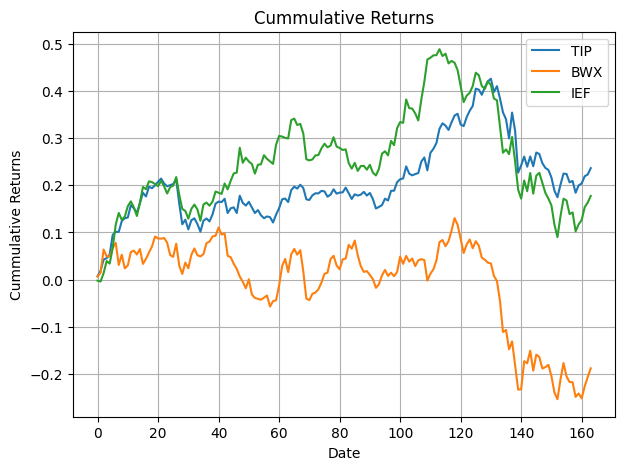

In [17]:
calc_cummulative_returns(excess_returns[['TIP', 'BWX', 'IEF']])

### 2.3 MV Frontier

In [18]:
w_t = tangency_weights(multi_asset_etf_excess_ret)
mv_frontier = w_t.merge(summary_stats_excess_returns['Sharpe'], on=w_t.index).rename(columns={'key_0':'assets'}).set_index('assets')
mv_frontier

,Tangent Weights,Sharpe
assets,,
BWX,2.7303,-0.1456
DBC,-0.1112,-0.0539
EEM,-0.6157,0.1498
EFA,0.5307,0.3616
HYG,-0.8326,0.4833
IEF,-4.6825,0.2206
IYR,0.8771,0.4594
PSP,0.2770,0.4314
QAI,7.2206,0.3052


In [19]:
w_tan_summary_stats = summary_statistics_annualized(excess_returns @ w_t, annual_factor=12)
w_tan_summary_stats

,Mean,Vol,Sharpe
Tangent Weights,-0.5273,0.3285,-1.6050


The ranking of the weights generally does not perfectly align with the ranking of the Sharpe ratio. Generally, the tangency portfolio will assign a bigger weight to assets that:
1. Have higher mean returns.

2. Have lower volatility (variance).

3. Have lower covariance with other assets.

Points (1) and (2) relate directly to Sharpe ratios: intuitively, the higher an asset's Sharpe ratio, the more you should hold of that asset.

Point (3), however, highlights the importance of covariance. Even an asset with a poor Sharpe ratio can be valuable in a portfolio if it has a low correlation with other assets. This asset may be optimized with a higher weight than assets with higher Sharpe ratios but higher correlations.

## 2.4 TIPS

## TIPS dropped from the dataset

In [20]:
w_t_without_tips = tangency_weights(multi_asset_etf_excess_ret.drop(columns=['TIP']))
w_t_without_tips.columns = ['Tangency Weights with TIPS dropped']
w_t_without_tips

,Tangency Weights with TIPS dropped
BWX,3.0159
DBC,-0.0910
EEM,-0.6642
EFA,0.5406
HYG,-0.8716
IEF,-4.8324
IYR,0.9902
PSP,0.3249
QAI,7.9769
SPY,-5.3893


In [21]:
w_tan_wo_tips_summary_statistics = summary_statistics_annualized(excess_returns.drop(columns=['TIP']) @ w_t_without_tips , annual_factor = 12)
w_tan_wo_tips_summary_statistics.index = ['Tangency Weights with TIPS dropped']
w_tan_wo_tips_summary_statistics

,Mean,Vol,Sharpe
Tangency Weights with TIPS dropped,-0.5808,0.3621,-1.6039


## TIPS Adjusted in the dataset

In [ ]:
TIP_adj = 0.0012
multi_asset_etf_excess_ret_adj = multi_asset_etf_excess_ret.copy()
# Add the adjustment
multi_asset_etf_excess_ret_adj['TIP'] += TIP_adj
# Get the tangency weights
w_t_adj_tips = tangency_weights(multi_asset_etf_excess_ret_adj) 
# Renaming the column name
w_t_adj_tips.columns = ['Tangency weights with TIPS adjusted']
w_t_adj_tips

,Tangency weights with TIPS adjusted
BWX,29.2601
DBC,1.7716
EEM,-5.1230
EFA,1.4514
HYG,-4.4601
IEF,-18.6046
IYR,11.3761
PSP,4.7252
QAI,77.4621
SPY,-49.9636


In [23]:
w_tan_adj_tips_summary_statistics = summary_statistics_annualized(multi_asset_etf_excess_ret_adj[multi_asset_etf_excess_ret_adj.columns[1:]] @ w_t_adj_tips , annual_factor = 12)
w_tan_adj_tips_summary_statistics.index = ['Tangency Weights with TIPS adjusted']
w_tan_adj_tips_summary_statistics

,Mean,Vol,Sharpe
Tangency Weights with TIPS adjusted,-6.1740,3.6558,-1.6888


Summarizing all the performance summary statistics:

In [24]:
pd.concat([w_tan_summary_stats,w_tan_wo_tips_summary_statistics,w_tan_adj_tips_summary_statistics])

,Mean,Vol,Sharpe
Tangent Weights,-0.5273,0.3285,-1.6050
Tangency Weights with TIPS dropped,-0.5808,0.3621,-1.6039
Tangency Weights with TIPS adjusted,-6.1740,3.6558,-1.6888


When the returns of TIPS are modified (+0.12% monthly), we see a decrease in the weight of TIPS in the tangency portfolio, now with a even more negative Sharpe. The decrease in Sharpe ratio of the tangency portfolio is seen as a positive fact for the investor: the Sharpe ratio increased in absolute value, which decreased the level of volatility necessary to target any return in the optimal portfolios.

The result might be at first counterintuitive, but it makes sense due to the investor's capacity to short the tangency portfolio and go long on the risk-free asset. Before the modification in TIPS, the investor could short the tangency portfolio and get a Sharpe of 1.6 for any target excess return. With the modification, the investor now can short the tangency portfolio (and go long on the risk-free asset) and get a Sharpe of 1.68 for any target excess return.

Conclusions on TIPS <br>
- Dropping TIPS from the investment set barely impacts the weights or the resulting performance. <br>
- Adjusting the mean of TIPS upward even just 1 standard error substantially impacts the allocations and moderately boosts the resulting performance.

Based on just a mean-variance analysis, it seems one could reasonably go either way with TIPS as an alternate asset class. In the argument to keep it separate, there is more diversification between TIPS and bonds than between SPY and many other equity buckets Harvard has. On the other hand, TIPS mostly impact the allocation to domestic bonds and might be seen as another asset in that bucket.

***

# 3. Allocations

<i>This section is graded for a good-faith effort by your group. Submit your write-up- along with your supporting code.

* Continue with the same data file as the previous section.

* Suppose the investor has a targeted mean excess return (per month) of $\mutarg$ = 0.01.

Build the following portfolios:

#### Equally-weighted (EW)
Rescale the entire weighting vector to have target mean $\mutarg$. Thus, the $i$ element of the weight vector is,
$$\wEW_i = \frac{1}{n}$$

#### “Risk-parity” (RP)
Risk-parity is a term used in a variety of ways, but here we have in mind setting the weight of the portfolio to be proportional to the inverse of its full-sample variance estimate. Thus, the $i$ element of the weight vector is,
$$\wRP_i = \frac{1}{\sigma_i^2}$$

#### Regularized (REG)
Much like the Mean-Variance portfolio, set the weights proportional to 
$$\wREG \sim \widehat{\Sigma}^{-1}\mux$$
but this time, use a regularized covariance matrix,
$$\widehat{\Sigma} = \frac{\Sigma + \Sigma_D}{2}$$
where $\Sigma_D$ denotes a *diagonal* matrix of the security variances, with zeros in the off-diagonals.

Thus, $\widehat{\Sigma}$ is obtained from the usual covariance matrix, $\Sigma$, but shrinking all the covariances to half their estimated values. 


### Comparing

In order to compare all these allocation methods, (those above, along with the tangency portfolio obtained in the previous section,) rescale each weight vector, such that it has targeted mean return of $\mutarg$.

* Calculate the performance of each of these portfolios over the sample.
* Report their mean, volatility, and Sharpe ratio. 
* How do these compare across the four allocation methods?

***

In [25]:
target_mean = .01
excess_returns = multi_asset_etf_excess_ret[multi_asset_etf_excess_ret.columns[1:]] 
w_t_without_tips.loc['TIP'] = 0
wts = pd.DataFrame(index = excess_returns.columns, columns = ['tangency','tangency with TIPS dropped',
                                                              'tangency with TIPS adjusted','equal weights',
                                                              'risk parity','regularized'])

wts.loc[:,'tangency'] = tangency_weights(multi_asset_etf_excess_ret, cov_mat = 1).values
wts.loc[:,'tangency with TIPS dropped'] = w_t_without_tips.values
wts.loc[:,'tangency with TIPS adjusted'] = w_t_adj_tips.values 
wts.loc[:,'equal weights'] = 1/len(excess_returns.columns) # w=(1/n) where n is the number of assets
wts.loc[:,'risk parity'] = 1/excess_returns.var() # w is reciprocal of the variances
wts.loc[:,'regularized'] = tangency_weights(multi_asset_etf_excess_ret, cov_mat = 0.5).values  # regularized, shrinking the off diagonal elements of cov matrix by 0.5

wts *= target_mean / (excess_returns.mean()@wts)

wts

,tangency,tangency with TIPS dropped,tangency with TIPS adjusted,equal weights,risk parity,regularized
BWX,-0.6214,-0.6231,-0.6385,0.2716,0.5229,-0.6754
DBC,0.0253,0.0188,-0.0387,0.2716,0.1229,-0.1362
EEM,0.1401,0.1372,0.1118,0.2716,0.1077,-0.0662
EFA,-0.1208,-0.1117,-0.0317,0.2716,0.1506,0.0373
HYG,0.1895,0.1801,0.0973,0.2716,0.5839,0.3168
IEF,1.0657,0.9984,0.4060,0.2716,0.8733,0.3935
IYR,-0.1996,-0.2046,-0.2483,0.2716,0.1213,0.0803
PSP,-0.0630,-0.0671,-0.1031,0.2716,0.0753,0.0495
QAI,-1.6433,-1.6481,-1.6905,0.2716,1.4522,-0.1565
SPY,1.1161,1.1135,1.0904,0.2716,0.1704,0.6237


In [26]:
summary_statistics_annualized(excess_returns @ wts)

,Mean,Vol,Sharpe
tangency,0.1200,0.0748,1.6050
tangency with TIPS dropped,0.1200,0.0748,1.6039
tangency with TIPS adjusted,0.1200,0.0798,1.5041
equal weights,0.1200,0.2915,0.4116
risk parity,0.1200,0.3095,0.3877
regularized,0.1200,0.1026,1.1695


***

# 4. Out-of-Sample Performance

<i>This section is not graded, and you do not need to submit it. Still, we may discuss it in class, in which case, you would be expected to know it.

## 1. One-step Out-of-Sample (OOS) Performance
Let’s divide the sample to both compute a portfolio and then check its performance out of sample.
* Using only data through the end of `2022`, compute the weights built in Section 3.
* Rescale the weights, (using just the in-sample data,) to set each allocation to have the same mean return of $\mutarg$.
* Using those weights, calculate the portfolio’s Sharpe ratio within that sample.
* Again using those weights, (derived using data through `2022`,) calculate the portfolio’s OOS Sharpe ratio, which is based only on performance in `2023-2024`.

## 2. Rolling OOS Performance

Iterate the Out-of-Sample performance every year, not just the final year. Namely,
* Start at the end of `2015`, and calculate the weights through that time. Rescale them using the mean returns through that time.
* Apply the weights to the returns in the upcoming year, (`2016`.)
* Step forward a year in time, and recompute.
* Continue until again calculating the weights through `2023` and applying them to the returns in `2024`.

Report the mean, volatility, and Sharpe from this dynamic approach for the following portfolios:
* mean-variance (tangency)
* equally-weighted
* risk-parity
* regularized

## 4.1

In [27]:
IN_SAMPLE_END_DATE = "2022-12-31"
OUT_OF_SAMPLE_START_DATE = "2023-01-01"

excess_returns_IS = multi_asset_etf_excess_ret.set_index('Date')[:IN_SAMPLE_END_DATE].reset_index()
excess_returns_OOS = multi_asset_etf_excess_ret.set_index('Date')[OUT_OF_SAMPLE_START_DATE:].reset_index() 

excess_returns_in_sample = excess_returns_IS[excess_returns_IS.columns[1:]] 
excess_returns_out_of_sample = excess_returns_OOS[excess_returns_OOS.columns[1:]] 

excess_returns_IS_adj = excess_returns_IS.copy()
excess_returns_IS_adj['TIP'] +=TIP_adj

In [28]:
target_mean = .01 # Target mean is 0.01
wts_IS = pd.DataFrame(index = excess_returns_IS.columns[1:], columns = ['tangency','tangency with TIPS dropped',
                                                                      'tangency with TIPS adjusted','equal weights',
                                                                      'risk parity','regularized'])

IS_tangency_weights_wo_TIPS = tangency_weights(excess_returns_IS.drop(columns={'TIP'}) , cov_mat = 1)
IS_tangency_weights_wo_TIPS.loc['TIP'] = 0
IS_tangency_weights_w_TIPS_adj = tangency_weights(excess_returns_IS_adj, cov_mat = 1)

wts_IS.loc[:,'tangency'] = tangency_weights(excess_returns_IS, cov_mat = 1).values
wts_IS.loc[:,'tangency with TIPS dropped'] = IS_tangency_weights_wo_TIPS.values
wts_IS.loc[:,'tangency with TIPS adjusted'] = IS_tangency_weights_w_TIPS_adj.values
wts_IS.loc[:,'equal weights'] = 1/len(excess_returns_in_sample.columns)
wts_IS.loc[:,'risk parity'] = 1/(excess_returns_in_sample.var())
wts_IS.loc[:,'regularized'] = tangency_weights(excess_returns_IS, cov_mat = 0.5).values


wts_IS *= target_mean / (excess_returns_in_sample.mean()@wts_IS) #scaling by the target mean

wts_IS

,tangency,tangency with TIPS dropped,tangency with TIPS adjusted,equal weights,risk parity,regularized
BWX,-0.5035,-0.5035,-0.5134,0.3096,0.6397,-0.7612
DBC,0.0809,0.0813,0.0198,0.3096,0.1239,-0.0746
EEM,0.1471,0.1473,0.1136,0.3096,0.1139,-0.0774
EFA,0.0040,0.0034,0.1122,0.3096,0.1598,0.0320
HYG,0.1691,0.1694,0.1167,0.3096,0.6024,0.3143
IEF,1.0974,1.1012,0.4214,0.3096,1.0610,0.6040
IYR,-0.1962,-0.1958,-0.2525,0.3096,0.1399,0.1144
PSP,-0.2488,-0.2484,-0.3259,0.3096,0.0829,0.0085
QAI,-1.8849,-1.8848,-1.9063,0.3096,1.5602,-0.3031
SPY,1.2033,1.2034,1.1827,0.3096,0.1794,0.6377


### in-sample performance

In [29]:
summary_statistics_annualized(excess_returns_in_sample @ wts_IS)

,Mean,Vol,Sharpe
tangency,0.1200,0.0721,1.6634
tangency with TIPS dropped,0.1200,0.0721,1.6634
tangency with TIPS adjusted,0.1200,0.0766,1.5668
equal weights,0.1200,0.3322,0.3613
risk parity,0.1200,0.3307,0.3629
regularized,0.1200,0.1048,1.1447


### out-of-sample performance

In [30]:
summary_statistics_annualized(excess_returns_out_of_sample @ wts_IS)

,Mean,Vol,Sharpe
tangency,0.0995,0.0996,0.9987
tangency with TIPS dropped,0.0996,0.0996,0.9997
tangency with TIPS adjusted,0.0817,0.1045,0.7819
equal weights,0.2511,0.3396,0.7393
risk parity,0.1934,0.4128,0.4684
regularized,0.1511,0.0980,1.5417


The performance of the tangency portfolio out-of-sample has the highest drop when compared to in-sample. On the other hand, Regularized portfolio performs better in the out-of-sample.

## 4.2

In [31]:
year_start = 2014
year_end = 2024
portOOS = pd.DataFrame(index =multi_asset_etf_excess_ret.set_index('Date').index,  columns=wts.columns,dtype=float)


for current_year in range(year_start, year_end):
    next_year = current_year + 1
    
    currentIS_excess_return = multi_asset_etf_excess_ret.set_index('Date').loc[:str(year_start)].reset_index()
    currentOOS_excess_return = multi_asset_etf_excess_ret.set_index('Date').loc[str(next_year)].reset_index()
    
    current_excess_returns_in_sample = currentIS_excess_return[currentIS_excess_return.columns[1:]] 
    current_excess_returns_out_of_sample = currentOOS_excess_return[currentOOS_excess_return.columns[1:]] 

    current_excess_returns_IS_adj = currentIS_excess_return.copy()
    current_excess_returns_IS_adj['TIP'] +=TIP_adj
    
    target_mean = .01
    wtsIS = pd.DataFrame(index=wts.index, columns=wts.columns, dtype=float)

    IS_tangency_weights_wo_TIPS = tangency_weights(currentIS_excess_return.drop(columns={'TIP'}) , cov_mat = 1)
    IS_tangency_weights_wo_TIPS.loc['TIP'] = 0
    IS_tangency_weights_w_TIPS_adj = tangency_weights(current_excess_returns_IS_adj, cov_mat = 1)

    wtsIS.loc[:,'tangency'] = tangency_weights(currentIS_excess_return, cov_mat = 1).values
    wtsIS.loc[:,'tangency with TIPS dropped'] = IS_tangency_weights_wo_TIPS.values
    wtsIS.loc[:,'tangency with TIPS adjusted'] = IS_tangency_weights_w_TIPS_adj.values
    wtsIS.loc[:,'equal weights'] = 1/len(current_excess_returns_in_sample.columns)
    wtsIS.loc[:,'risk parity'] = 1/(current_excess_returns_in_sample.var())
    wtsIS.loc[:,'regularized'] = tangency_weights(currentIS_excess_return, cov_mat = 0.5).values


    wtsIS *= target_mean / (current_excess_returns_in_sample.mean()@wtsIS)
    portOOS.loc[str(next_year)] = currentOOS_excess_return.set_index('Date') @ wtsIS


portOOS.tail()

,tangency,tangency with TIPS dropped,tangency with TIPS adjusted,equal weights,risk parity,regularized
Date,,,,,,
2024-05-31,0.0331,0.0323,0.0336,0.0561,0.0406,0.0294
2024-06-30,0.0292,0.0298,0.0287,0.0036,0.0033,0.0166
2024-07-31,0.0118,0.0141,0.0102,0.0553,0.0485,0.0246
2024-08-31,0.0114,0.0131,0.0102,0.0287,0.0250,0.0152
2024-09-30,0.0074,0.0091,0.0062,0.0558,0.0402,0.0090


In [32]:
summary_statistics_annualized(portOOS)

,Mean,Vol,Sharpe
tangency,0.0801,0.0877,0.9134
tangency with TIPS dropped,0.0763,0.0873,0.8739
tangency with TIPS adjusted,0.0827,0.0885,0.9352
equal weights,0.0993,0.2628,0.3777
risk parity,0.0395,0.1711,0.2306
regularized,0.0483,0.0819,0.5890


In [33]:
portOOS = pd.DataFrame(index =multi_asset_etf_excess_ret.set_index('Date').index,  columns=wts.columns,dtype=float)

for i, month in enumerate(portOOS.index):
    if i > 50:
        currentIS_excess_return = multi_asset_etf_excess_ret.set_index('Date').iloc[:i].reset_index()
        currentOOS_excess_return = multi_asset_etf_excess_ret.set_index('Date').iloc[i]

        OOS = multi_asset_etf_excess_ret.set_index('Date').iloc[i].reset_index()
        current_excess_returns_in_sample = currentIS_excess_return[currentIS_excess_return.columns[1:]] 
        current_excess_returns_out_of_sample = OOS[OOS.columns[1:]] 
        
        current_excess_returns_IS_adj = currentIS_excess_return.copy()
        current_excess_returns_IS_adj['TIP'] +=TIP_adj

        target_mean = .01
        wtsIS = pd.DataFrame(index=wts.index, columns=wts.columns, dtype=float)

        IS_tangency_weights_wo_TIPS = tangency_weights(currentIS_excess_return.drop(columns={'TIP'}) , cov_mat = 1)
        IS_tangency_weights_wo_TIPS.loc['TIP'] = 0
        IS_tangency_weights_w_TIPS_adj = tangency_weights(current_excess_returns_IS_adj, cov_mat = 1)

        wtsIS.loc[:,'tangency'] = tangency_weights(currentIS_excess_return, cov_mat = 1).values
        wtsIS.loc[:,'tangency with TIPS dropped'] = IS_tangency_weights_wo_TIPS.values
        wtsIS.loc[:,'tangency with TIPS adjusted'] = IS_tangency_weights_w_TIPS_adj.values
        wtsIS.loc[:,'equal weights'] = 1/len(current_excess_returns_in_sample.columns)
        wtsIS.loc[:,'risk parity'] = 1/(current_excess_returns_in_sample.var())
        wtsIS.loc[:,'regularized'] = tangency_weights(currentIS_excess_return, cov_mat = 0.5).values


        wtsIS *= target_mean / (current_excess_returns_in_sample.mean()@wtsIS)
        portOOS.iloc[i,:] = currentOOS_excess_return @ wtsIS




    
portOOS.tail()

,tangency,tangency with TIPS dropped,tangency with TIPS adjusted,equal weights,risk parity,regularized
Date,,,,,,
2024-05-31,0.0305,0.0307,0.0342,0.0720,0.0922,0.0397
2024-06-30,0.0573,0.0572,0.0529,0.0045,0.0078,0.0318
2024-07-31,-0.0217,-0.0219,-0.0281,0.0686,0.1036,0.0077
2024-08-31,-0.0035,-0.0036,-0.0059,0.0343,0.0483,0.0073
2024-09-30,-0.0044,-0.0046,-0.0069,0.0658,0.0809,-0.0002


In [34]:
summary_statistics_annualized(portOOS)


,Mean,Vol,Sharpe
tangency,0.0864,0.0841,1.0273
tangency with TIPS dropped,0.0885,0.0836,1.0583
tangency with TIPS adjusted,0.0898,0.0893,1.0059
equal weights,0.1704,0.3491,0.4882
risk parity,0.0838,0.3075,0.2726
regularized,0.0556,0.1030,0.5397


***

# 5. Without a Riskless Asset

<i>This section is not graded, and you do not need to submit it. Still, we may discuss it in class, in which case, you would be expected to know it.

Re-do Section 2 above, but in the model without a risk-free rate.

That is, build the MV allocation using the two-part formula in the `Mean-Variance` section of the notes.
* This essentially substitutes the risk-free rate with the minimum-variance portfolio.
* Now, the allocation depends nonlinearly on the target mean return, $\mutarg$. (With a risk-free rate, we simply scale the weights up and down to achieve the mean return.)

You will find that, conceptually, the answers are very similar. 

The data is provided in total returns, (in which case you should ignore the SHV column,) as well as excess returns, (where SHV has been subtracted from the other columns.)


## Calculating the Weights of the GMV using Total Return

In [35]:
multi_asset_etf_tot_ret = pd.read_excel(multiassetETF_data, sheet_name = 'total returns')
risk_free_rate = multi_asset_etf_tot_ret.loc[:,['SHV']]
multi_asset_etf_tot_ret = multi_asset_etf_tot_ret.drop('SHV', axis = 1)
multi_asset_etf_tot_ret.head()

,Date,BWX,DBC,EEM,EFA,HYG,IEF,IYR,PSP,QAI,SPY,TIP
0,2011-02-28,0.0066,0.0417,-0.0004,0.0355,0.0144,-0.0021,0.0452,0.0401,0.0026,0.0347,0.0072
1,2011-03-31,0.0084,0.0266,0.0629,-0.0239,0.0004,-0.0015,-0.0109,0.0167,0.0055,0.0001,0.0119
2,2011-04-30,0.0488,0.0456,0.0273,0.0563,0.0160,0.0184,0.0466,0.0587,0.0190,0.0290,0.0238
3,2011-05-31,-0.0135,-0.0517,-0.0294,-0.0221,0.0013,0.0251,0.0101,-0.0416,0.0000,-0.0112,0.0027
4,2011-06-30,-0.0001,-0.0426,-0.0094,-0.0121,-0.0057,-0.0050,-0.0311,-0.0426,-0.0108,-0.0169,0.0075


In [36]:
def calc_gmv_weights(
    returns: pd.DataFrame,
    return_graphic: bool = False,
    return_port_ret: bool = False,
    target_ret_rescale_weights: Union[float, None] = None,
    name: str = 'GMV'
):
    """
    Calculates Global Minimum Variance (GMV) portfolio weights.

    Parameters:
    returns (pd.DataFrame): Time series of returns.
    return_graphic (bool, default=False): If True, plots the GMV weights.
    return_port_ret (bool, default=False): If True, returns the portfolio returns.
    target_ret_rescale_weights (float or None, default=None): Target return for rescaling weights.
    name (str, default='GMV'): Name for labeling the portfolio.

    Returns:
    pd.DataFrame or pd.Series: GMV portfolio weights or portfolio returns if `return_port_ret` is True.
    """
    returns = returns.copy()

    if 'date' in returns.columns.str.lower():
        returns = returns.rename({'Date': 'date'}, axis=1)
        returns = returns.set_index('date')
    returns.index.name = 'date'

    ones = np.ones(returns.columns.shape)
    cov = returns.cov()
    cov_inv = np.linalg.inv(cov)
    scaling = 1 / (np.transpose(ones) @ cov_inv @ ones)
    gmv_tot = scaling * cov_inv @ ones
    gmv_wts = pd.DataFrame(
        index=returns.columns,
        data=gmv_tot,
        columns=[f'{name} Weights']
    )
    port_returns = returns @ gmv_wts.rename({f'{name} Weights': f'{name} Portfolio'}, axis=1)

    if isinstance(target_ret_rescale_weights, (float, int)):
        scaler = target_ret_rescale_weights / port_returns[f'{name} Portfolio'].mean()
        gmv_wts[[f'{name} Weights']] *= scaler
        port_returns *= scaler
        gmv_wts = gmv_wts.rename(
            {f'{name} Weights': f'{name} Weights Rescaled Target {target_ret_rescale_weights:.2%}'},
            axis=1
        )
        port_returns = port_returns.rename(
            {f'{name} Portfolio': f'{name} Portfolio Rescaled Target {target_ret_rescale_weights:.2%}'},
            axis=1
        )

    if return_graphic:
        gmv_wts.plot(kind='bar', title=f'{name} Weights')

    if return_port_ret:
        return port_returns

    return gmv_wts

In [37]:
wts_gmv = calc_gmv_weights(multi_asset_etf_tot_ret)
wts_gmv

,GMV Weights
BWX,-0.1285
DBC,-0.0060
EEM,-0.0648
EFA,0.0229
HYG,0.1122
IEF,-0.0354
IYR,-0.0333
PSP,-0.1228
QAI,1.1402
SPY,-0.1160


## Calculating the Weights of the Tangency Portfolio using Total Return

In [38]:
w_t_totalreturn = tangency_weights(multi_asset_etf_tot_ret)
w_t_totalreturn


,Tangent Weights
BWX,-1.2885
DBC,0.0352
EEM,0.1604
EFA,-0.1835
HYG,0.4970
IEF,1.8644
IYR,-0.4056
PSP,-0.2858
QAI,-1.3385
SPY,1.8366


In [39]:
total_returns_weights = pd.concat([w_t_totalreturn, wts_gmv], axis=1)
total_returns_weights

,Tangent Weights,GMV Weights
BWX,-1.2885,-0.1285
DBC,0.0352,-0.0060
EEM,0.1604,-0.0648
EFA,-0.1835,0.0229
HYG,0.4970,0.1122
IEF,1.8644,-0.0354
IYR,-0.4056,-0.0333
PSP,-0.2858,-0.1228
QAI,-1.3385,1.1402
SPY,1.8366,-0.1160


In [40]:
multi_asset_etf_tot_ret_dateindex = multi_asset_etf_tot_ret.set_index('Date')
w_gmv_summary_stats = summary_statistics_annualized(multi_asset_etf_tot_ret_dateindex @ wts_gmv, annual_factor=12)
w_gmv_summary_stats.T

,GMV Weights
Mean,0.0085
Vol,0.0266
Sharpe,0.3191


In [41]:
multi_asset_etf_tot_ret_dateindex = multi_asset_etf_tot_ret.set_index('Date')
w_tan_summary_stats_totret = summary_statistics_annualized(multi_asset_etf_tot_ret_dateindex @ w_t_totalreturn, annual_factor=12)
w_tan_summary_stats_totret.T

,Tangent Weights
Mean,0.2221
Vol,0.1362
Sharpe,1.6315


In [42]:
summary_stat = pd.concat([w_tan_summary_stats_totret.T, w_gmv_summary_stats.T], axis=1)
summary_stat

,Tangent Weights,GMV Weights
Mean,0.2221,0.0085
Vol,0.1362,0.0266
Sharpe,1.6315,0.3191


In [43]:
def calc_tangency_weights(
    returns: pd.DataFrame,
    cov_mat: str = 1,
    return_graphic: bool = False,
    return_port_ret: bool = False,
    target_ret_rescale_weights: Union[None, float] = None,
    annual_factor: int = 12,
    name: str = 'Tangency'
):
    """
    Calculates tangency portfolio weights based on the covariance matrix of returns.

    Parameters:
    returns (pd.DataFrame): Time series of returns.
    cov_mat (str, default=1): Covariance matrix for calculating tangency weights.
    return_graphic (bool, default=False): If True, plots the tangency weights.
    return_port_ret (bool, default=False): If True, returns the portfolio returns.
    target_ret_rescale_weights (float or None, default=None): Target return for rescaling weights.
    annual_factor (int, default=12): Factor for annualizing returns.
    name (str, default='Tangency'): Name for labeling the weights and portfolio.

    Returns:
    pd.DataFrame or pd.Series: Tangency portfolio weights or portfolio returns if `return_port_ret` is True.
    """
    returns = returns.copy()
    
    if 'date' in returns.columns.str.lower():
        returns = returns.rename({'Date': 'date'}, axis=1)
        returns = returns.set_index('date')
    returns.index.name = 'date'

    if cov_mat == 1:
        cov_inv = np.linalg.inv((returns.cov() * annual_factor))
    else:
        cov = returns.cov()
        covmat_diag = np.diag(np.diag((cov)))
        covmat = cov_mat * cov + (1 - cov_mat) * covmat_diag
        cov_inv = np.linalg.pinv((covmat * annual_factor))  
        
    ones = np.ones(returns.columns.shape) 
    mu = returns.mean() * annual_factor
    scaling = 1 / (np.transpose(ones) @ cov_inv @ mu)
    tangent_return = scaling * (cov_inv @ mu)
    tangency_wts = pd.DataFrame(
        index=returns.columns,
        data=tangent_return,
        columns=[f'{name} Weights']
    )
    port_returns = returns @ tangency_wts.rename({f'{name} Weights': f'{name} Portfolio'}, axis=1)

    if return_graphic:
        tangency_wts.plot(kind='bar', title=f'{name} Weights')

    if isinstance(target_ret_rescale_weights, (float, int)):
        scaler = target_ret_rescale_weights / port_returns[f'{name} Portfolio'].mean()
        tangency_wts[[f'{name} Weights']] *= scaler
        port_returns *= scaler
        tangency_wts = tangency_wts.rename(
            {f'{name} Weights': f'{name} Weights Rescaled Target {target_ret_rescale_weights:.2%}'},
            axis=1
        )
        port_returns = port_returns.rename(
            {f'{name} Portfolio': f'{name} Portfolio Rescaled Target {target_ret_rescale_weights:.2%}'},
            axis=1
        )

    if cov_mat != 1:
        port_returns = port_returns.rename(columns=lambda c: c.replace('Tangency', f'Tangency Regularized {cov_mat:.2f}'))
        tangency_wts = tangency_wts.rename(columns=lambda c: c.replace('Tangency', f'Tangency Regularized {cov_mat:.2f}'))
        
    if return_port_ret:
        return port_returns
    return tangency_wts


In [44]:
total_return_portfolios = pd.concat([
    calc_gmv_weights(multi_asset_etf_tot_ret, return_port_ret=True),
    calc_tangency_weights(multi_asset_etf_tot_ret, return_port_ret=True)
], axis=1)
total_return_portfolios


,GMV Portfolio,Tangency Portfolio
date,,
2011-02-28,-0.0044,0.0209
2011-03-31,0.0016,-0.0043
2011-04-30,0.0092,-0.0303
2011-05-31,0.0094,0.0498
2011-06-30,-0.0022,-0.0039
...,...,...
2024-05-31,0.0064,0.0628
2024-06-30,0.0021,0.1033
2024-07-31,0.0014,-0.0298


In [45]:
total_returns_weights['Tangent Weights']

BWX   -1.2885
DBC    0.0352
EEM    0.1604
EFA   -0.1835
HYG    0.4970
IEF    1.8644
IYR   -0.4056
PSP   -0.2858
QAI   -1.3385
SPY    1.8366
TIP    0.1084
Name: Tangent Weights, dtype: float64

In [46]:
r_v = total_return_portfolios["GMV Portfolio"].mean()
r_p = 0.01 # Target Monthly Mean of 1%
r_t = total_return_portfolios["Tangency Portfolio"].mean()
omega = (r_p - r_v) / (r_t - r_v)
print(f"Omega: {omega:.4f}")

Omega: 0.5219


In [47]:
target_return_weight = total_returns_weights['Tangent Weights'] * omega + total_returns_weights['GMV Weights']*(1-omega)
target_return_weight

BWX   -0.7339
DBC    0.0155
EEM    0.0528
EFA   -0.0848
HYG    0.3130
IEF    0.9561
IYR   -0.2276
PSP   -0.2079
QAI   -0.1535
SPY    0.9031
TIP    0.1673
dtype: float64

In [48]:
total_returns_weights['Target Return 1% Weights'] = target_return_weight
total_returns_weights

,Tangent Weights,GMV Weights,Target Return 1% Weights
BWX,-1.2885,-0.1285,-0.7339
DBC,0.0352,-0.0060,0.0155
EEM,0.1604,-0.0648,0.0528
EFA,-0.1835,0.0229,-0.0848
HYG,0.4970,0.1122,0.3130
IEF,1.8644,-0.0354,0.9561
IYR,-0.4056,-0.0333,-0.2276
PSP,-0.2858,-0.1228,-0.2079
QAI,-1.3385,1.1402,-0.1535
SPY,1.8366,-0.1160,0.9031


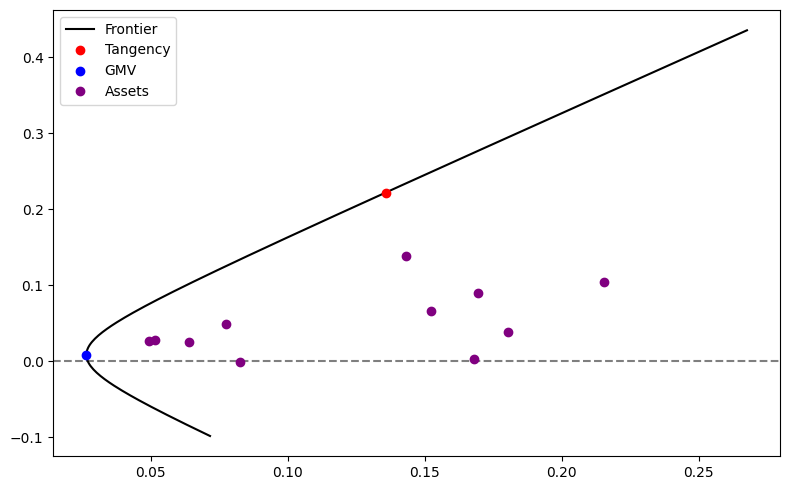

In [49]:
def calc_efficient_frontier(returns, omega_range=[-0.5, 2], return_graphic=False, figsize=(8, 5), annual_factor = 12):
    omega_range = [min(omega_range[0], 0), max(omega_range[1], 1)]
    gmv_returns = calc_gmv_weights(returns, return_port_ret=True).squeeze()
    tangency_returns = calc_tangency_weights(returns, return_port_ret=True).squeeze()
    omega_to_efficient_frontier_dict = {}

    for omega in range(int(omega_range[0] * 100), int(omega_range[1] * 100) + 1, 1):
        target_returns = tangency_returns.values * omega / 1e2 + gmv_returns.values * (1 - omega / 1e2)
        omega_to_efficient_frontier_dict[f"{(omega / 1e2):.2f}"] = [target_returns.mean() * annual_factor, target_returns.std() * np.sqrt(annual_factor)]

    efficient_frontier = pd.DataFrame(omega_to_efficient_frontier_dict, index=["Return", "Volatility"]).transpose()

    if not return_graphic:
        return efficient_frontier
    
    plt.figure(figsize=figsize)
    plt.axhline(y=0, linestyle='--', color='black', alpha=0.5)
    plt.plot(
        efficient_frontier['Volatility'],
        efficient_frontier['Return'],
        linestyle='-', marker='', color="black", label="Frontier"
    )
    plt.plot(
        efficient_frontier.loc["1.00", "Volatility"],
        efficient_frontier.loc["1.00", 'Return'], 
        linestyle='', marker='o', color="red", label="Tangency"
    )
    plt.plot(
        efficient_frontier.loc["0.00", "Volatility"],
        efficient_frontier.loc["0.00", 'Return'],
        linestyle='', marker='o', color="blue", label="GMV"
    )

    plt.plot(
        returns.std() * np.sqrt(annual_factor),
        returns.mean() * annual_factor, 
        linestyle='', marker='o', color="purple", label="Assets"
    )
    plt.legend()
    plt.tight_layout()
    plt.show()

calc_efficient_frontier(multi_asset_etf_tot_ret_dateindex, return_graphic=True)

***